<a href="https://colab.research.google.com/github/KuanChihLee/Generative-Adversarial-Networks/blob/master/CGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Reference
Github Resouce: https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan

#### This program reuse the model structure in DCGAN_MNIST project. Furthermore, this program will establish a conditional deep convolutional GAN, as well as testing on MNIST.

In [0]:
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import multiply, Embedding
from keras.layers import BatchNormalization
from keras.layers import Conv2D, Conv1D, UpSampling2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop

import os
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

Using TensorFlow backend.


In [0]:
class CGAN():
  def __init__(self, width=28, height=28, channels=1, 
               latent_dim=100, num_class=10):
    
    '''  Build network graph '''
    self.width = width
    self.height = height
    self.channels = channels
    self.latent_dim = latent_dim
    self.num_class = num_class
    self.shape = (self.width, self.height, self.channels)
    
    optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)
    
    self.G = self.__generator()
    self.D = self.__discriminator()
    self.D.compile(loss='binary_crossentropy', 
                                optimizer=optimizer, 
                                metrics=['accuracy'])
    
    # Generate fake images
    noise = Input(shape=(self.latent_dim,))
    label = Input(shape=(1,))
    gen_img = self.G([noise, label])
    
    # Classify fake images by discriminator
    # Train Discriminator
    result = self.D([gen_img, label])
    
    # stack Generator and Discriminator
    # Train Generator only
    self.D.trainable = False
    self.stack_model = Model([noise, label], result)
    self.stack_model.compile(loss='binary_crossentropy', 
                             optimizer=optimizer, 
                             metrics=['accuracy'])
  def __generator(self):
    
    '''  Build Generator '''
    # DCGAN structure
    model = Sequential()
    model.add(Dense(7*7*512, input_shape=(self.latent_dim,)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(Reshape((7,7,512)))
    model.add(Dropout(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(256, 5, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, 5, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(1, 5, padding='same'))
    model.add(Activation('tanh'))
    
    #model.summary()
    
    # Considering 'conditions'
    noise = Input(shape=(self.latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    embed_label = Flatten()(Embedding(self.num_class, self.latent_dim)(label))
    condi_input = multiply([noise, embed_label])
    condi_img = model(condi_input)
    
    # Create a new Model receive [noise, label] as input and outpur condi_img
    # New Model will call old model function
    return Model([noise, label], condi_img)
  
  def __discriminator(self):
    
    '''  Build Discriminator '''
    model = Sequential()
    model.add(Reshape(self.shape, input_shape=(1,np.prod(self.shape))))
    model.add(Conv2D(64, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, 5, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    #model.summary()
    
    # Considering 'conditions'
    gen_img = Input(shape=self.shape)
    label = Input(shape=(1,), dtype='int32')
    
    embed_label = Flatten()(Embedding(self.num_class, np.prod(self.shape), input_length=1)(label))
    flat_gen_img = Flatten()(gen_img)
    condi_input = multiply([flat_gen_img, embed_label])
    condi_input = Reshape(self.shape)(condi_input)
    
    condi_result = model(condi_input)
    
    # Create a new Model receive [gen_img, label] as input and outpur condi_result
    # New Model will call old model function
    return Model([gen_img, label], condi_result) 
  
  def train(self, X_train, y_train, epochs=5000, batch=128, save_interval=100):
    
    '''  Train CGAN '''
    for cnt in range(epochs+1):
    
      ## train discriminator
      idx = np.random.randint(0, X_train.shape[0], size=batch)
      ground_image, ground_label = X_train[idx,:,:,:], y_train[idx]

      # create generative images with conditions (ground labels)
      gen_noise = np.random.normal(0, 1, size=[batch, 100])
      gen_image = self.G.predict([gen_noise, ground_label.reshape(-1, 1)])

      # feed gounds images, generative images, ground labels and target labels
      # into discriminator
      ground_y_batch = np.concatenate((ground_label, ground_label), axis=None)
      ground_y_batch = ground_y_batch.reshape(-1, 1)
      
      x_combined_batch = np.concatenate((ground_image, gen_image))
      y_combined_batch = np.concatenate((np.ones((batch, 1)), np.zeros((batch, 1))))
      
      d_loss = self.D.train_on_batch([x_combined_batch, ground_y_batch], y_combined_batch)
      
      ## train generator
      input_noise = np.random.normal(0, 1, size=[batch, 100])  
      sampled_labels = np.random.randint(0, 10, batch).reshape(-1, 1)
      y_mislabled = np.ones((batch, 1))

      # Note. discriminator only judge whether (generative image is HD and label is correct)
      # That's why y_mislabeled is np.ones
      g_loss = self.stack_model.train_on_batch([input_noise, sampled_labels], y_mislabled)

      if cnt % 100 == 0:
        print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss[0])) 

      if cnt % save_interval == 0:
        self.plot_images(save2file=True, step=cnt)

  def plot_images(self, save2file=False, samples=16, step=0):
    
    ''' Plot and generated images '''
    if not os.path.exists("./images_CGAN"):
      os.makedirs("./images_CGAN")
    filename = "./images_CGAN/mnist_%d.png" % step

    gen_noise = np.random.normal(0, 1, (10, 100))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)
    gen_image = self.G.predict([gen_noise, sampled_labels])

    plt.figure(figsize=(15, 8))
    for i in range(gen_image.shape[0]):
      plt.subplot(2, 5, i+1)
      image = gen_image[i, :, :, :]
      image = np.reshape(image, [28, 28])
      plt.imshow(image, cmap='gray')
      plt.title("Digit: %d" % sampled_labels[i])
      plt.axis('off')
    plt.tight_layout()

    if save2file:
      plt.savefig(filename)
      plt.close('all')
    else:
      plt.show()

In [0]:
## Read data
(X_train, y_train), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)
print(y_train.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 28, 28, 1)
(60000,)


In [0]:
cgan = CGAN()
cgan.train(X_train, y_train, epochs=3001, save_interval=100)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.693233], [ Generator :: loss: 0.691239]
epoch: 100, [Discriminator :: d_loss: 0.684825], [ Generator :: loss: 0.706826]
epoch: 200, [Discriminator :: d_loss: 0.680478], [ Generator :: loss: 0.728406]
epoch: 300, [Discriminator :: d_loss: 0.690206], [ Generator :: loss: 0.702860]
epoch: 400, [Discriminator :: d_loss: 0.687978], [ Generator :: loss: 0.715608]
epoch: 500, [Discriminator :: d_loss: 0.692378], [ Generator :: loss: 0.698363]
epoch: 600, [Discriminator :: d_loss: 0.693622], [ Generator :: loss: 0.697345]
epoch: 700, [Discriminator :: d_loss: 0.693664], [ Generator :: loss: 0.702070]
epoch: 800, [Discriminator :: d_loss: 0.693549], [ Generator :: loss: 0.683682]
epoch: 900, [Discriminator :: d_loss: 0.697102], [ Generator :: loss: 0.695962]
epoch: 1000, [Discriminator :: d_loss: 0.690938], [ Generator :: loss: 0.698449]
epoch: 1100, [Discriminator :: d_loss: 0.690304], [ Generator :: loss: 0.697824]
epoch: 1200, [Discriminator :: d_loss: 0

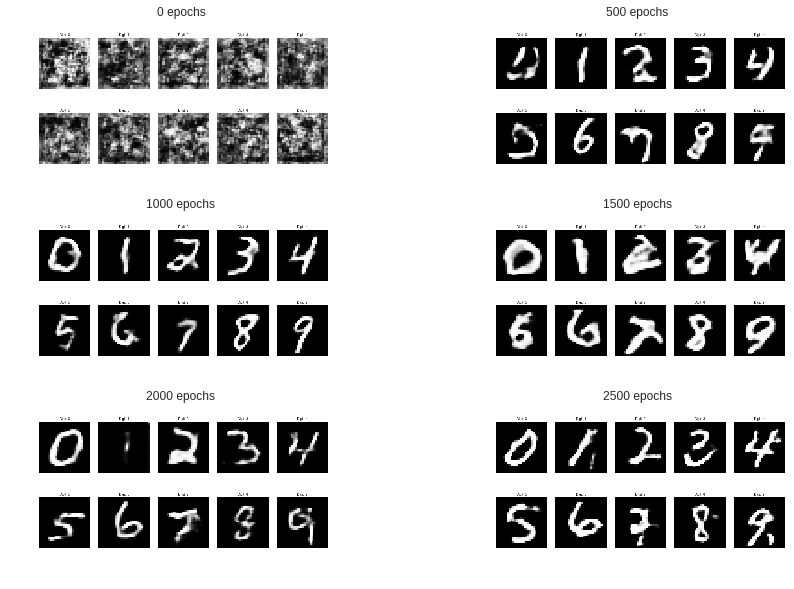

In [0]:
import matplotlib.image as mpimg
plt.figure(figsize=(15,10))
for i in range(6):
  img_name = './images_CGAN/mnist_%d.png' % (i*500)
  title_name = '%d epochs' % (i*500)
  img=mpimg.imread(img_name)
  plt.subplot(3,2,i+1)
  plt.imshow(img)
  plt.title(title_name)
  plt.axis('off')

(-0.5, 1079.5, 575.5, -0.5)

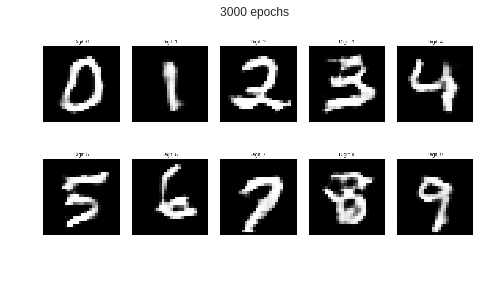

In [0]:
img_name = './images_CGAN/mnist_3000.png'
title_name = '3000 epochs'
img=mpimg.imread(img_name)
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.title(title_name)
plt.axis('off')